# Predicting the Stock Market with Linear Regression

In this notebook we will be using historical data on the price of the S&P500 Index to make a predictive model and predictions about future prices. The S&P500 is a stock market index that aggregates the stock prices of 500 large companies, more information on the S&P500 can be found [here](https://en.wikipedia.org/wiki/S%26P_500_Index). Predicting whether the index will go up or down will help forecast how the stock market as a whole will perform. 
 

First We'll import the necessary libraries

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style


from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## The Dataset

we will be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in `sphist.csv`.

The columns of the dataset are:

- `Date` -- The date of the record.
- `Open` -- The opening price of the day (when trading starts).
- `High` -- The highest trade price during the day.
- `Low` -- The lowest trade price during the day.
- `Close` -- The closing price for the day (when trading is finished).
- `Volume` -- The number of shares traded.
- `Adj Close` -- The daily closing price, adjusted retroactively to include any corporate actions. Read more here.


we will be using this dataset to develop the predictive model. 

In [2]:
#Read in data
data = pd.read_csv('all_stocks_5yr.csv')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
#Get Info
data.info()
data.drop('Name',axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [4]:
# Format Date Column as datetime
data['date'] = pd.to_datetime(data['date'])
#Add values in columns based on Data
data = data.groupby('date').sum()

In [5]:
#Sanity Check date column
data.reset_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


In [6]:
#Sort in oldest to newest
data.sort_values('date', inplace=True)
data.head()

,date,open,high,low,close,volume
0,2013-02-08,27640.7155,27921.8201,27513.9195,27783.4792,2210298420
1,2013-02-11,27777.2448,27934.5706,27555.6742,27737.5652,1948002462
2,2013-02-12,27761.1488,27975.0913,27586.5503,27800.3376,2438463132
3,2013-02-13,27835.9584,28036.1691,27627.4817,27839.0995,2442872925
4,2013-02-14,27745.6670,28026.0848,27547.0611,27833.2166,2609614514


Text(0, 0.5, 'Price')

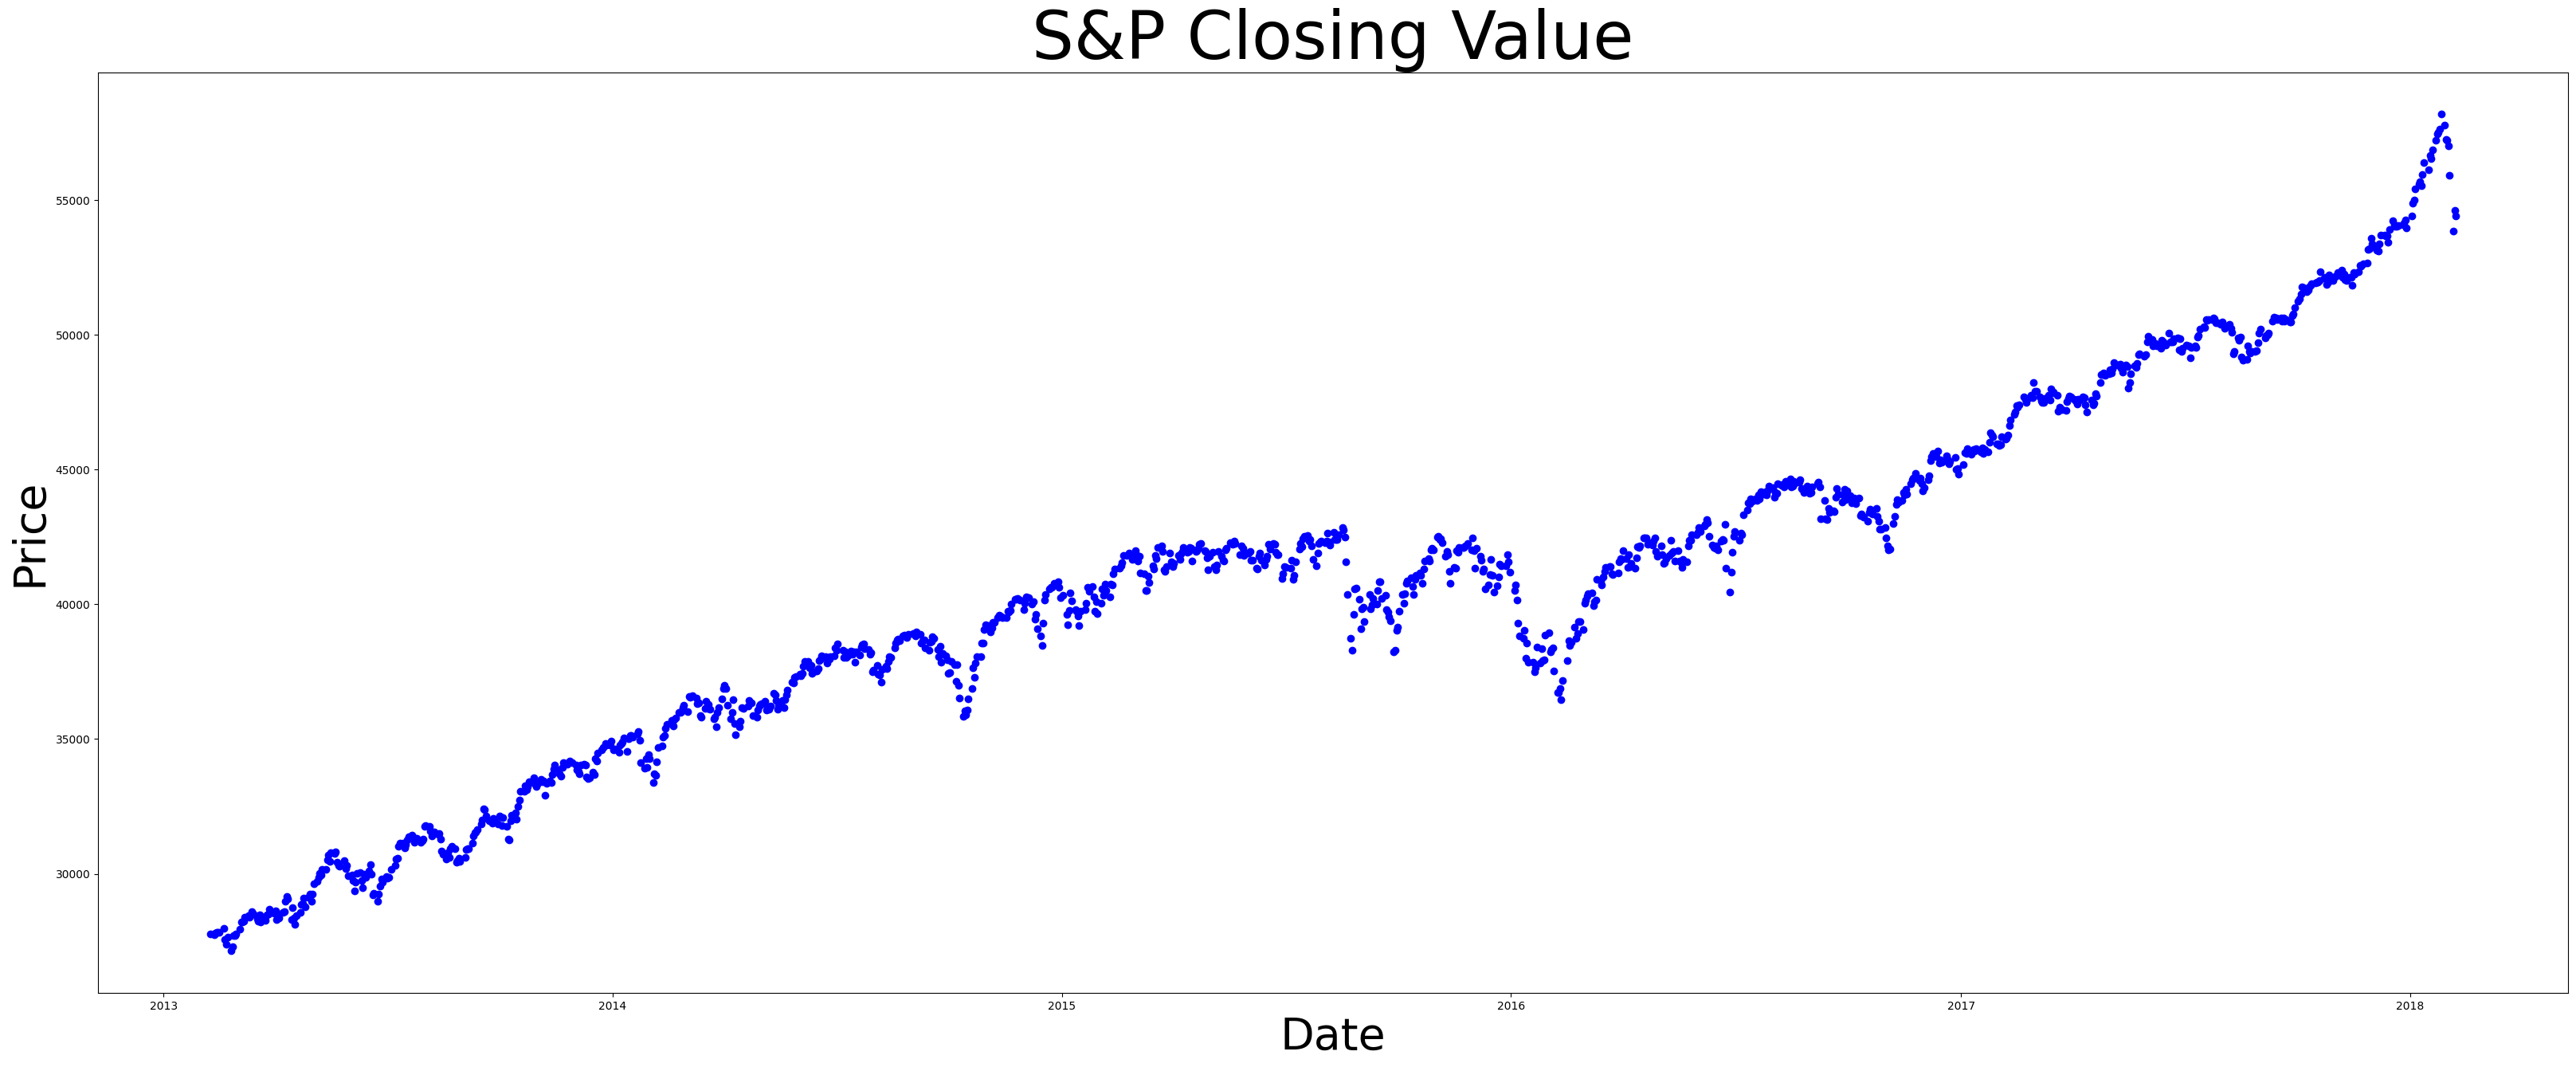

In [7]:
#Plot Closing Value
plt.figure(figsize=(40,15))
plt.scatter(data['date'], data['close'], c='b')
plt.title('S&P Closing Value', fontsize=60)
plt.xlabel('Date', fontsize=40)
plt.ylabel('Price', fontsize=40)

## Generate Features

In a normal machine learning exercise, each row is treated independently. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and can't be treated as such.

This means We'll have to be extra careful to not inject "future" knowledge into past rows when we do training and prediction. Injecting future knowledge will make our model look good when we are training and testing it, but will result in fail in the real world.

The time series nature of the data means that we can generate indicators to make our model more accurate. This will incorporate information from multiple prior rows into one, and will make predictions much more accurate.

We will create the following features:
- `5_day_avg` - The average price from the past 5 days.
- `30_day_avg` - The average price for the past 30 days.
- `year_avg` - The average price for the past 365 days.
- `avg_ratio`- The ratio between the average price for the past 5 days, and the average price for the past 365 days.
- `5_day_std` - The standard deviation of the price over the past 5 days.
- `year_std`- The standard deviation of the price over the past 365 days.
- `std_ratio`- The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.

In [8]:
# The rolling mean and standard deviation will use the current day's price. 
# I use .he shift method to reindex the resulting series to shift all the values "forward" one day. 
# For example, the rolling mean calculated for 1950-01-03 will need to be assigned to 1950-01-04, and so on. 
data['5_day_avg'] = data['close'].rolling(window=5).mean().shift(1)
data['30_day_avg']= data['close'].rolling(window=5).mean().shift(1)
data['year_avg'] = data['close'].rolling(window=365).mean().shift(1)
data['avg_ratio'] = data['5_day_avg']/data['year_avg']

data['5_day_std'] = data['close'].rolling(window=5).std().shift(1)
data['year_std'] = data['close'].rolling(window=365).mean().shift(1)
data['std_ratio'] = data['5_day_std']/data['year_std']

In [9]:
data.head(20)

,date,open,high,low,close,volume,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
0,2013-02-08,27640.7155,27921.8201,27513.9195,27783.4792,2210298420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-11,27777.2448,27934.5706,27555.6742,27737.5652,1948002462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-02-12,27761.1488,27975.0913,27586.5503,27800.3376,2438463132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-02-13,27835.9584,28036.1691,27627.4817,27839.0995,2442872925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-02-14,27745.6670,28026.0848,27547.0611,27833.2166,2609614514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-02-15,27839.3272,28051.9977,27593.7881,27816.0928,2729859527,27798.73962,27798.73962,NaN,NaN,41.216883,NaN,NaN
6,2013-02-19,27834.3735,28120.4448,27650.2195,27971.0608,2510597666,27805.26234,27805.26234,NaN,NaN,40.776368,NaN,NaN
7,2013-02-20,27942.3641,28093.7667,27496.5128,27567.7468,2697916964,27851.96146,27851.96146,NaN,NaN,68.288059,NaN,NaN
8,2013-02-21,27496.4367,27668.9461,27135.6955,27372.7500,2876059263,27805.44330,27805.44330,NaN,NaN,146.582989,NaN,NaN
9,2013-02-22,27496.2010,27770.9257,27326.4791,27650.3488,2213908522,27712.17340,27712.17340,NaN,NaN,239.029638,NaN,NaN


## Split Data

Some of the indicators use 365 days of historical data, and the dataset starts on 1950-01-03. Thus, the first 365 rows  don't have enough historical data to compute all the indicators. I'll remove these rows before I split the data into a training and testing set. 

We'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.

In [10]:
data = data.dropna(axis=0)
data.isnull().sum()

date          0
open          0
high          0
low           0
close         0
volume        0
5_day_avg     0
30_day_avg    0
year_avg      0
avg_ratio     0
5_day_std     0
year_std      0
std_ratio     0
dtype: int64

In [11]:
train = data[data['date']< datetime(year=2016, month=1, day=1)] 
train

,date,open,high,low,close,volume,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
365,2014-07-23,38475.9759,38745.8625,38208.3792,38498.3084,1934687425,38171.24032,38171.24032,32956.596275,1.158228,202.632848,32956.596275,0.006148
366,2014-07-24,38557.5273,38865.5313,38246.7616,38537.1457,2155970752,38225.50842,38225.50842,32985.951972,1.158842,251.685874,32985.951972,0.007630
367,2014-07-25,38400.0352,38671.5373,38103.7073,38361.0291,1715294393,38361.43306,38361.43306,33015.539864,1.161921,175.149747,33015.539864,0.005305
368,2014-07-28,38338.7777,38600.3524,37987.2120,38332.1657,1815386153,38387.00108,38387.00108,33044.473265,1.161677,160.463969,33044.473265,0.004856
369,2014-07-29,38386.7092,38630.7072,38025.5540,38160.2943,2021459803,38427.74654,38427.74654,33073.221392,1.161899,87.815201,33073.221392,0.002655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2015-12-24,41448.6196,41692.1449,41223.8963,41433.6080,736263173,40942.04446,40942.04446,40449.810354,1.012169,393.945514,40449.810354,0.009739
726,2015-12-28,41298.4129,41592.6136,40978.0003,41421.8166,1345470298,41014.24060,41014.24060,40458.595670,1.013734,452.574219,40458.595670,0.011186
727,2015-12-29,41657.8092,42087.5840,41449.6227,41851.3720,1381510021,41209.50070,41209.50070,40468.360859,1.018314,343.268044,40468.360859,0.008482
728,2015-12-30,41770.0361,42003.1096,41437.6423,41564.9051,1196763384,41439.46146,41439.46146,40478.273689,1.023746,300.385330,40478.273689,0.007421


In [12]:
test = data[data["date"] > datetime(year=2016, month=1, day=1)]
test

,date,open,high,low,close,volume,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
730,2016-01-04,40554.6489,40852.3577,39902.9719,40502.9315,2709068370,41492.45678,41492.45678,40495.306470,1.024624,241.686972,40495.306470,0.005968
731,2016-01-05,40716.2491,41144.6230,40237.0370,40709.3650,2272335846,41306.32148,41306.32148,40500.798588,1.019889,508.948848,40500.798588,0.012566
732,2016-01-06,40122.9522,40668.7601,39720.6858,40171.3564,2715403317,41163.83116,41163.83116,40506.749874,1.016222,565.158425,40506.749874,0.013952
733,2016-01-07,39495.6059,40094.9153,38981.6197,39310.9776,3155709703,40827.82804,40827.82804,40511.709675,1.007803,553.493324,40511.709675,0.013663
734,2016-01-08,39525.7054,39836.8060,38657.9424,38816.0919,2852388646,40377.04254,40377.04254,40514.391351,0.996610,701.237169,40514.391351,0.017308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2018-02-01,56999.4800,57761.8966,56348.8878,57005.0900,2491742144,57618.58800,57618.58800,48595.708333,1.185672,403.385599,48595.708333,0.008301
1255,2018-02-02,56674.3900,57134.8043,55628.0156,55907.5300,2751594961,57491.72400,57491.72400,48629.923084,1.182229,486.403545,48629.923084,0.010002
1256,2018-02-05,55496.1900,56314.1252,53453.0462,53839.2150,3598437288,57035.37600,57035.37600,48661.082109,1.172094,694.295751,48661.082109,0.014268
1257,2018-02-06,52893.4350,54986.5812,52290.2905,54625.4200,4072080890,56244.44000,56244.44000,48686.342634,1.155241,1452.616746,48686.342634,0.029836


## Making Predictions

Now I will build a model and make predictions. I will use the [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error), also called MAE, as an error metric, because it will show how "close" the predictions are to the price in intuitive terms.


In [13]:
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', '5_day_avg',
       '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std', 'year_std',
       'std_ratio'],
      dtype='object')

In [14]:
features = ['5_day_avg', '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std',
       'year_std', 'std_ratio']
y_train = train['close']
y_test = test['close']

model = LinearRegression()
model.fit(train[features], y_train) 
predictions = model.predict(test[features]) 
mae = mean_absolute_error(test['close'], predictions)
mae



541.9205448803659

Text(0, 0.5, 'Stock Price')

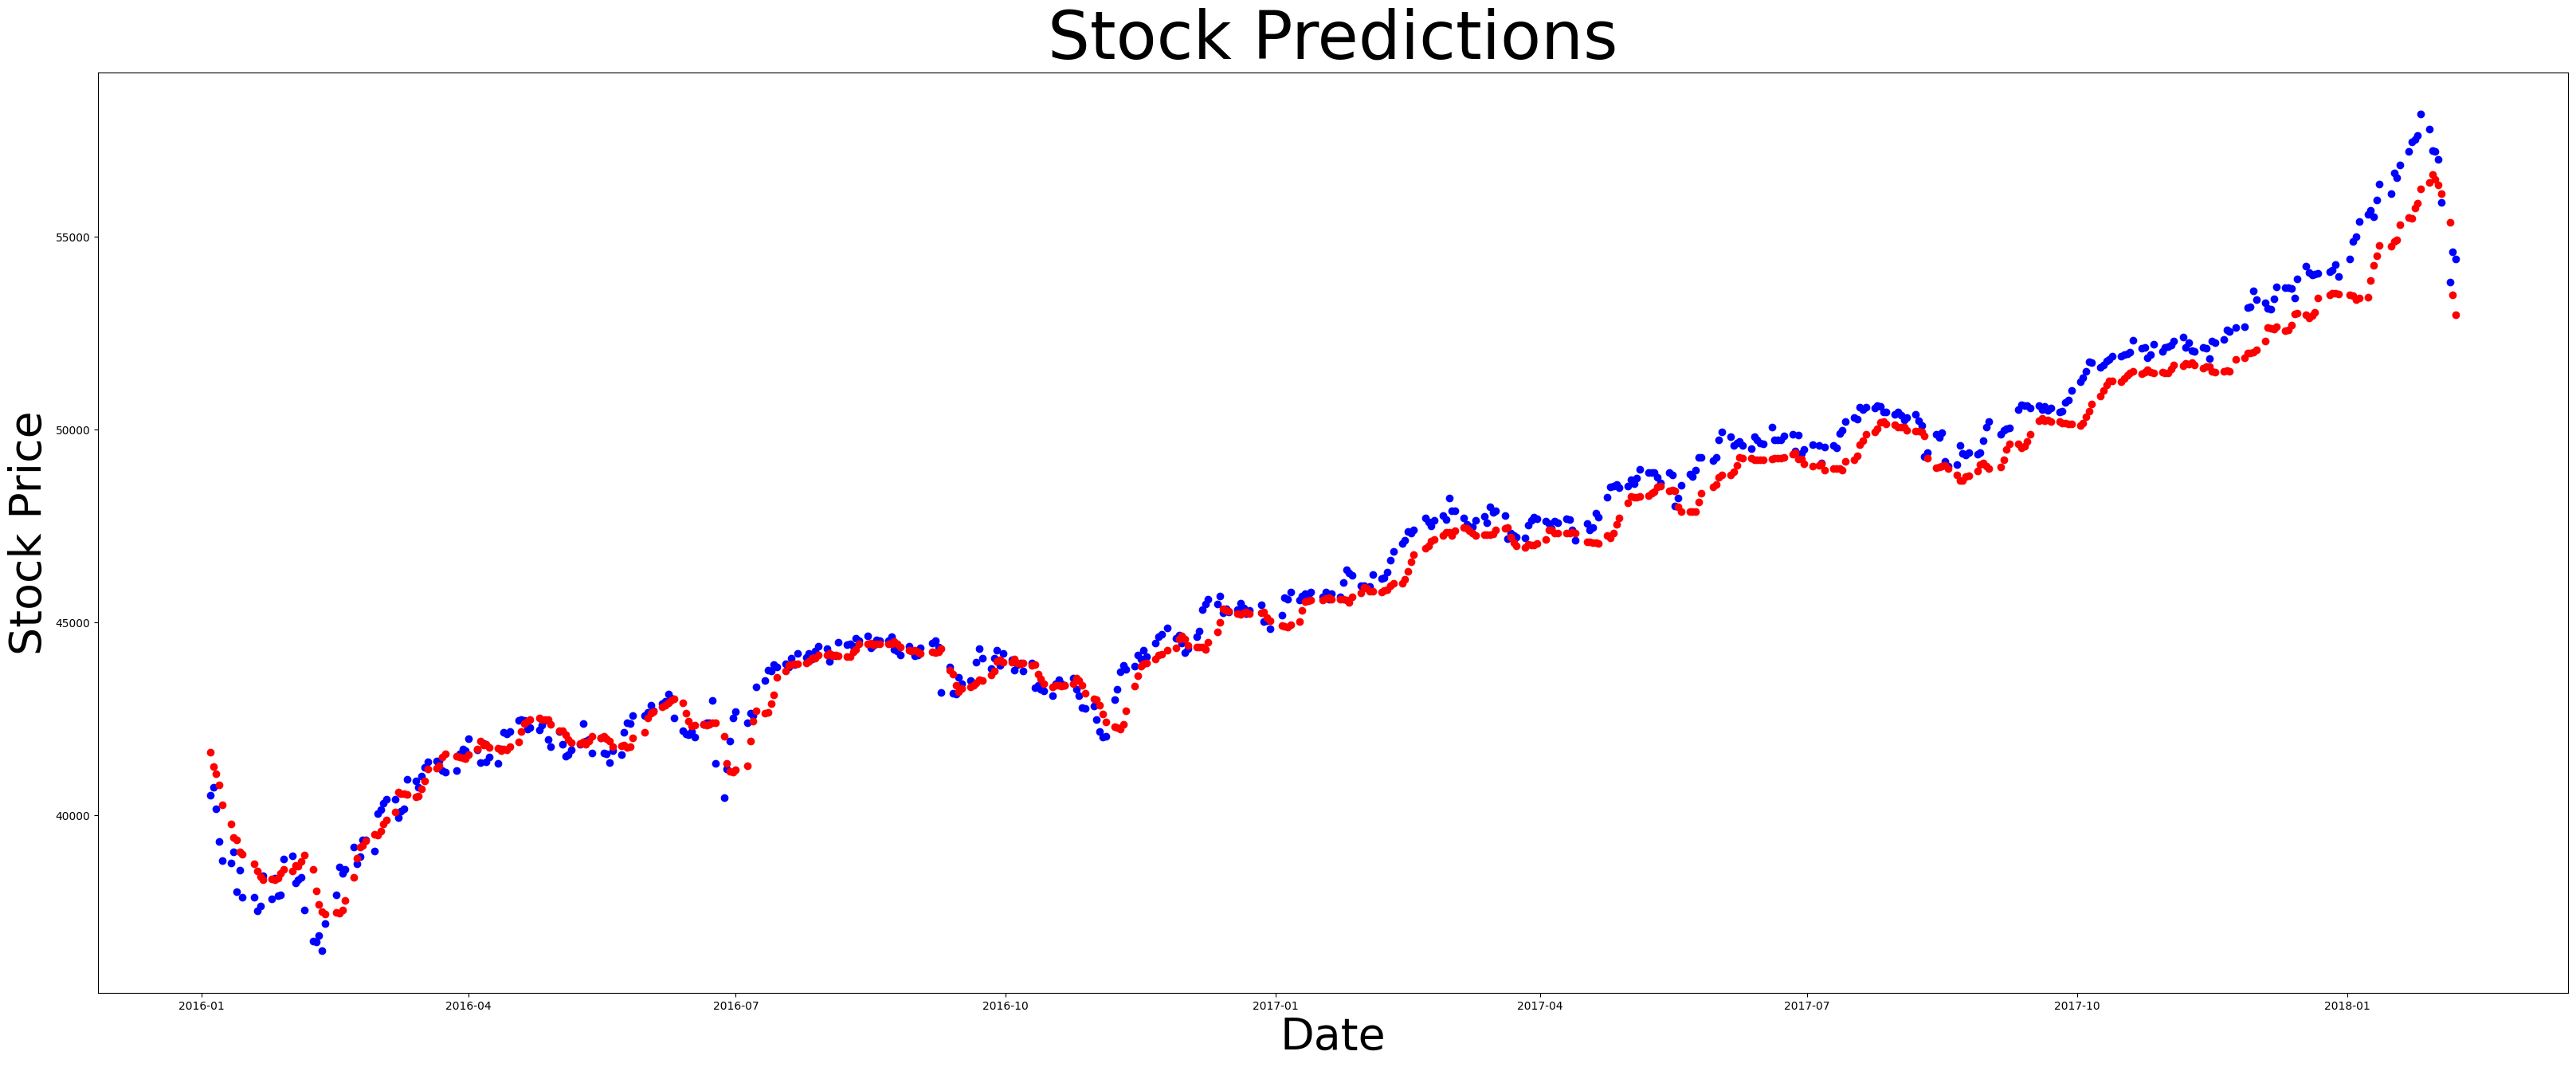

In [15]:
plt.figure(figsize=(40,15))
plt.scatter(test['date'], test['close'], c='b')
plt.scatter(test['date'], predictions, c='r')
plt.title('Stock Predictions', fontsize=60)
plt.xlabel('Date', fontsize=40)
plt.ylabel('Stock Price', fontsize=40)


### Improvement Ideas (future)

- Accuracy would improve greatly by making predictions only one day ahead. For example, train a model using data from 1951-01-03 to 2013-01-02, make predictions for 2013-01-03, and then train another model using data from 1951-01-03 to 2013-01-03, make predictions for 2013-01-04, and so on. This more closely simulates what to do if you want to trade using the algorithm.

- Try other techniques, like a random forest, and see if they perform better.

- Incorporate outside data, such as the weather in New York City (where most trading happens) the day before, and the amount of Twitter activity around certain stocks.

- Make the system real-time by writing an automated script to download the latest data when the market closes, and make predictions for the next day.

- Make the system "Higher-Resolution". Make hourly, minute-by-minute, or second by second predictions. This will require obtaining extensive data though.